# Variational Inference

##### Keywords: variational inference, ELBO, CAVI, kl-divergence, normal distribution, mixture model, gaussian mixture model, mean-field approximation, latent variables, optimization

In [22]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import pymc3 as pm

//anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


Variational Inference (VI)  approximates probability distributions through optimization. Specifically, it finds wide applicability in approximating difficult-to-compute probability distributions, a problem that is especially important in Bayesian Inference to estimate posterior distributions. 

It serves the same purpose as traditional MCMC algorithms. The idea behind VI is to first posit a family of distributions and then to find the member of that family which is close to the target, where closeness is measured using the Kullback-Leibler divergence.

## Core Idea

Consider a general problem of Bayesian Inference - Let the latent variables in our problem be $Z$ and the observed data $X$. The latent variables drawn from prior distributions $[p(z)]$ relate to the data through the likelihood $p(x \vert z)$. To draw inference on the latent variables we condition them on the data and compute the posterior. In complex models, this computation can only be done through approximate inference.
  
This is usually done using MCMC approaches. However in some situations, like when large data sets are involved or if the model is too complex, we may need to approximate the posterior faster and that is where VI provides a strong alternative.

As in EM, we start by writing the full-data likelihood

$$ p(x, z) = p(z) * p(x \vert z) \\
p(z \vert x) = \frac{p(x,z)}{p(x)} $$

The **difference with EM** here is that we now consider $z$ to be all our parameters, not just specific parameters such as cluster membership or missing data. (In other words $z$ is now $\theta$ plus the previous $z$).

The core idea - we restrict ourselves a family of approximate distributions D over the latent variables. We then try to find the member of that family that minimizes the Kullback-Leibler divergence to the exact posterior. This reduces to solving an optimization problem. 

$$ q^*(z) = \underset{q(z) \in D}{\arg\min}\quad KL(q(z) \vert  \vert p(z \vert x)) $$

The goal is to approximate $p(z \vert x)$ with the resulting $q(z)$. We optimize $q(z)$ for minimal value of KL divergence 

![](images/VI.png)

The above figure (from 10.1, Bishop) shows two approximate distributions trying to capture the true underlying posterior. 

### VI vs MCMC


MCMC |  VI  | 
-------------  | :-------------:
More computationally intensive |  Less intensive 
Guarantess producing asymptotically exact samples from target distribution  |  No such guarantees
Slower  |  Faster, especially for large data sets and complex distributions
Best for precise inference  |  Useful to explore many scenarios quickly or large data sets

## Approximate inference

The inference problem is to compute the conditional given by the below equation. 

$$p(z \vert x) = \frac{p(x,z)}{p(x)} $$

In this equation, the denominator is the marginal distribution of the data obtained by marginalizing all the latent variables from the joint distribution p(x,z). It is also called the evidence and it is this marginalization that is unavailable in closed form or requires exponential time to compute which is why inference in such models is hard. Hence, the need for approximate inference.

**So, what are the various pieces required to successfully set up the optimization for Variational Inference and find the approximation to the posterior?**

The first is the objective function to be optimized - aka, the ELBO

### ELBO - Evidence lower bound - Objective function to be optimized

The KL divergence that we are trying to minimize to find the approximation to the original posterior distribution is given by the below equation. Looking at the equation, it is clear that p(x) [the evidence] is a dependency in the computation, which as we have already mentioned is hard to compute. Hence, we are back to square one in that the KL divergence we are trying to minimize to find the approximation is itself dependent on the same evidence that led us to look for an approximation in the first place.

Since we cannot compute the KL directly, we compute an alternative objective that is equivalent to the KL upto an added constant. This is the ELBO.

We know from our discussion of EM that:

$$  KL + ELBO = log(p(x)) $$

As the RHS is independent of the values of the latent variables, it can be considered constant for our inference. Thus, minimizing KL is equivalent to maximizing ELBO.

![](images/klsplitup.png)

This illustration from Bishop(2006) captures the relationship between all three terms in the final equation above.

The ELBO is given by

$$ ELBO(q) = E_q[(log(p(z,x))] - E_q[log(q(z))] $$ 

We have seen this equation from EM where we had to keep track of $\theta$ and $\theta_{old}$. Remember that we are now trying to find the posterior distrib for this $\theta$, we have just renamed it $z$.

The first term of the ELBO immediately above is the expected complete log-likelihood, which is optimized by the EM algorithm. The EM algorithm was designed for finding maximum likelihood estimates in models
with latent variables. It uses the fact that the ELBO is equal to the log likelihood log p(x)
(i.e., the log evidence) when $q(z) = p(z \vert x)$. EM alternates between computing the expected
complete log likelihood according to $p(z \vert x)$ (the E step) and optimizing it with respect to the
model parameters (the M step). Unlike variational inference, EM assumes the expectation
under $p(z \vert x)$ is computable and uses it in otherwise difficult parameter estimation problems.

The ELBO is also given by:

$$ ELBO(q) = E_q[log\, \frac{p(z, x)}{q(z)}] = E_q[log\, \frac{p(x \vert z) p(z)}{q(z)}] = E_q[log\, p(x \vert z)] + E_q[log \, \frac{p(z)}{q(z)}]$$

Thus:

$$ ELBO(q) = E_{q(z)}[(log(p(x \vert z))] - KL(q(z) \vert  \vert p(z)) $$ 

Some observations:

1) The first term is an expected likelihood and so the ELBO encourages distributions to place their mass on configurations of latent variables that explain the observed data. The second term is the negative divergence between the variational distribution and the prior, hence it encourages distributions close to the prior. Thus, it maintains the usual balance between likelihood and prior  
2) The ELBO lower bounds the log evidence and hence the name

#### Note: For the rest of the notebook, the expectation is always taken with respect to q(z) unless otherwise specified

### Variational family - Mean-field approximation

Now that we have specified the variational objective function with the ELBO, we now need to specify the variational family of distributions from which we pick the approximate variational distribution. This will then complete the full specification of our optimization problem.  
As might be intuited, the complexity of the family of distributions from which we pick our approximate distribution determines the complexity of the optimization. The more flexibility in the family of distributions, the closer the approximation and the harder the optimization.

A common family of distributions to pick is the Mean-field variational family. Here, the latent variables are mutually independent and each governed by a distinct factor in the variational distribution. A generic member of the mean-field variational family is given by the below equation - 

$$ q(z) = \prod_{j=1}^m q_j(z_j) $$

As of now, we have not specified the parametric form of the individual variational factors. Each can take on any paramteric form corresponding to the latent variable. For example, a continuous variable might have a Gaussian factor whereas a categorical variable will typically have a categorical factor.

Below is an example where a 2D Gaussian Posterior is approximated by a mean-field variational structure with independent gaussians in the 2 dimensions

![](images/vi2dg.png)

The variational posterior in green cannot capture the strong correlation in the original posterior because of the mean field approximation.

Notice that we are not making any comment about the conditional independence or lack thereof of posterior parameters. We are merely saying we will find new functions of these parameters such that we can multiply these functions to construct an approximate posterior.

## Optimization algorithm : Coordinate ascent mean-field variational inference (CAVI)

Having specified our objective function and the variational family of distributions from which to pick the approximation, we now work to optimize.  

CAVI maximizes ELBO by iteratively optimizing each variational factor of the mean-field variational distribution, while holding the others fixed. It however, does not guarantee finding the global optimum. 

The algorithm is:

**Input**: $p(x,z)$ with data set $x$ (RHS of bayes theorem)

**Output**: $q(z) = \prod_j q_j(z_j)$

**Initialize**: $q_j(z_j)$


`while ELBO has not converged (or z have not converged):`

    for each j:
    
$$q_j \propto exp(E_{-j}[log p(z_j \vert z_{-j}, x])$$
        
    compute ELBO

Some results and definitions to explain above algorithm -   

1) Complete conditional of a latent variable is defined as the conditional distribution of the latent variable given all of the other latent variables in the model and data  
2) Then, given that we fix the value of all other variational factors $q_l(z_l)$ ($l$ not equal to $j$), the optimal $q_j(z_j)$ is proportional to the exponentiated expected log of the complete conditional. This then is equivalent to being proportional to the log of the joint because the mean-field family assumes that all the latent variables are independent.

$$ Complete \hspace{0.1cm} Conditional \hspace{0.1cm} of \hspace{0.1cm} z_j = p(z_j \vert \boldsymbol{z_{-j},x}) $$

$$ q_j^*(z_j) \propto \exp\{E_{-j}[log(p(z_j \vert \boldsymbol{z_{-j},x}))]\} \\
\implies q_j^*(z_j) \propto \exp\{E_{-j}[log(p(z_j,\boldsymbol{z_{-j},x}))]\} $$


Note that the expectations above are with respect to the variational distribution over $\boldsymbol{z_{-j}}$:

$$\boldsymbol{\prod_{l{\neq}j}}q_l(z_l) $$

### Derivation - How did we get this result?

Writing the ELBO as a function of one variational factor plus added constants (the terms related to the other variational factors), we seek to optimize each factor one at a time by iteratively updating them. In this process, the ELBO keeps climbing up to reach a local optimum.   
Below, we rewrite the first term using iterated expectation and for the second term, we have only retained the term that depends on q_j(z_j)

$$ ELBO(q) = E[(log(p(z,x))] - E[log(q(z))] \\
\implies ELBO(q_j) = E_j[E_{-j}[log(p(z_j, \boldsymbol{z_{-j},x}))]] - E_j[log(q_j(z_j))] + constants \\
\implies ELBO(q_j) = E_j[A] - E_j[log(q_j(z_j))] + constants $$

In this final equation, upto an added constant, the RHS is equal to the negative KL divergence between $q_j$ and $exp(A)$. Thus, maximizing this expression is the same as minimizing the KL divergence between $q_j$ and $exp(A)$.   

This occurs when $q_j = exp(A)$.

Hence, the above result that leads us to CAVI.

## Complete Example - Bayesian Mixture of Gaussians

### Problem specification

The goal here is to infer the latent variables that govern the observed data using Bayesian inference. We choose to model the data as a mixture of Gaussians. The inference is done using Variational Inference.

![](images/Gaussian_Mixture_Model.png)

The above figure from Bishop is graphical model representing a mixture of Gaussians

We'll restrict ourselves to a bayesian mixture of unit-variance univariate Gaussians - 

Assume there are K mixture components corresponding to K normal distributions where the K independent means are drawn from a Gaussian prior with zero mean and fixed variance (can be assumed to be a hyperparameter).   
For each observation i, we first choose a cluster assignment that indicates which one of the K clusters the observation comes from. This is defined by a categorical distribution with uniform density. We then draw the observation from the corresponding Gaussian mixture component. 

$$ \boldsymbol{\mu} = \{\mu_1, ..., \mu_K\} \\
\mu_k \sim \mathcal{N}(0, \sigma^{2}), \hspace{1cm} k = 1, ..., K \\
c_i \sim Categorical(\frac{1}{K}, ..., \frac{1}{K}), \hspace{1cm} i = 1, ..., n \\
x_i \vert c_i, \boldsymbol{\mu} \sim \mathcal{N}(c_i^T\boldsymbol{\mu}, 1), \hspace{1cm} i = 1, ..., n \\
$$


The joint distribution over n observations and the latent variables can be given by - 

$$ p(\boldsymbol{\mu, c, x}) = p(\boldsymbol{\mu})\boldsymbol{\prod_{i=1}^{n}}p(c_i)p(x_i \vert c_i,\boldsymbol{\mu}) $$

and the evidence can thus be calculated as:

$$p(\boldsymbol{x}) = \int d\boldsymbol{\mu} p(\boldsymbol{\mu})\prod_{i=1}^n \sum_{c_i} p(c_i) p(x_i \vert c_i, \boldsymbol{\mu})$$

This integral does not teduce to a product of 1-d integrals for each of the $\mu$s.

Remember from our MCMC with mixtures that there are as many parameters as there are assignments, ie one assignment for each data point. (this is one of the reasons that unless we marginalize over the discrete parameters, it is hard to sample from mixture models)

The latent variables are the K class means and the n class assignments - $$ \boldsymbol{z} = \{\boldsymbol{\mu, c}\} $$

Now, we specify the mean-field variational family to approximate our Bayesian posterior distributions. 

$$ q(\boldsymbol{\mu, c}) = \boldsymbol{\prod_{k=1}^K} q(\mu_k;m_k, s_k^2)\boldsymbol{\prod_{i=1}^n}q(c_i;w_i) $$

As discussed earlier, each latent variable has its own variational factor. The first factor is a Gaussian distribution on the kth mixture component's mean, parameterized by its own mean and variance (note these are not the same as the means of the cluster gaussian as these are completely different distributions!). The second factor is a distribution on the ith observation's mixture assignment with assignment probabilities given by a K-vector $w_i$, and $c_i$ being the bit-vector (with one 1) associated with data point $i$.

Having specified the joint distribution and now the mean-field family, we have now completely specified the variational inference problem for the mixture of Gaussians. The optimization will now focus on maximizing the ELBO with respect to the variational parameters for each latent variable. 

### Solve for the ELBO 

Derive the ELBO as a function of the variational factors

$$ ELBO(q) = E[(log(p(z,x))] - E[log(q(z))] \\
\implies ELBO(\boldsymbol{m,s^2,w}) = \sum_{k=1}^{K}E[log(p(\mu_k));m_k,s_k^2] \\
+ \sum_{i=1}^n(E[log(p(c_i));w_i] + E[log(p(x_i \vert c_i,\boldsymbol{\mu}));w_i,\boldsymbol{m,s^2}]) \\
- \sum_{i=1}^nE[log(q(c_i;w_i))] - \sum_{k=1}^KE[log(q(\mu_k;m_k,s_k^2))] $$

### Obtaining the CAVI updates

Next, we derive the CAVI update for the variatonal factors.  
  
We first start with the update for the cluster assignment factor.   

We separate the terms that depend on the cluster assignment vs those that don't. We then compute the expectation with respect to the remaining variational factors. 

$$ q_j^*(z_j) \propto \exp\{E_{-z_j}[log(p(z_j,\boldsymbol{z_{-j},x}))]\} $$

Since we are talking about the assignment of the ith point, we can drop all points $j \ne i$ and terms for the $k$ means(see the expression for the ELBO avove):

$$\implies q^*(c_i;w_i) \propto \exp\{log(p(c_i)) + E_{-z_i}[log(p(x_i \vert c_i,\boldsymbol{\mu}));\boldsymbol{m,s^2}]\} \\
log(p(c_i)) = log(\frac{1}{K}) \\
p(x_i \vert c_i,\boldsymbol{\mu}) = \prod_{k=1}^Kp(x_i \vert \mu_{k})^{c_{ik}} \\ 
E_{-z_i}[log(p(x_i \vert c_i,\boldsymbol{\mu}))] = \sum_kc_{ik}E_{-z_i}[log(p(x_i \vert \mu_k));m_k,s_k^2] \\
\implies E_{-z_i}[log(p(x_i \vert c_i,\boldsymbol{\mu}))] = \sum_kc_{ik}E_{-z_i}[-0.5(x_i-\mu_k)^2;m_k,s_k^2] + constants \\
\implies E_{-z_i}[log(p(x_i \vert c_i,\boldsymbol{\mu}))] = \sum_kc_{ik}(E_{-z_i}[\mu_k;m_k,s_k^2]x_i - E_{-z_i}[\mu_k^2;m_k,s_k^2]/2) + constants $$

Substituting back into the first equation and removing terms that are constant with respect to c_i, we get the final CAVI update below. As is evident, the update is purely a function of the other variational factors and can thus be easily computed.

$$ w_{ik} = q^{*}(z_i = k) \propto \exp\{E_{-z_i}[\mu_k;m_k,s_k^2]x_i - E_{-z_i}[\mu_k^2;m_k,s_k^2]/2\} $$

Next, we compute the variational distribution of the kth mixture component mean. Intuitively, these posteriors are gaussian as the conditional distribution of $\mu_k$ is a gaussian with the data being the data "assigned" to the $kth$ cluster.


$$ q(\mu_k) \propto \exp\{log(p(\mu_k)) + \sum_{i=1}^{n}E_{-\mu_k}[log(p(x_i \vert c_i,\boldsymbol{\mu}));w_i,\boldsymbol{m_{-k},s_{-k}^2}]\} \\
$$

Note that c_i is an indicator vector and so, 

$$ w_{ik} = E_{-\mu_k}[c_{ik};w_i] $$

Then, working through the un-normalized equations, we see that the CAVI update for the kth mixture component takes the form of a Gaussian distribution parameterized by the derived mean and variance.

$$ log(q(\mu_k)) = log(p(\mu_k)) + \sum_i E_{-\mu_k}[log(p(x_i \vert c_i,\boldsymbol{\mu}));w_i,\boldsymbol{m_{-k},s_{-k}^2}] + constants \\
\implies log(q(\mu_k)) = log(p(\mu_k)) + \sum_i E_{-\mu_k}[c_{ik}log(p(x_i \vert \mu_k));w_i] + constants \\
\implies log(q(\mu_k)) = -\mu_k^2/2\sigma^2 + \sum_i E_{-\mu_k}[c_{ik};w_i]log(p(x_i \vert \mu_k)) + constants \\
\implies log(q(\mu_k)) = -\mu_k^2/2\sigma^2 + \sum_i w_{ik} (-(x_i - \mu_k)^2/2) + constants \\
\implies log(q(\mu_k)) = -\mu_k^2/2\sigma^2 + \sum_i (w_{ik}x_i\mu_k - w_{ik}\mu_k^2/2) + constants \\ 
\implies log(q(\mu_k)) = (\sum_i w_{ik}x_i)\mu_k - (1/2\sigma^2 + \sum_i w_{ik}/2)\mu_k^2 + constants \\
\implies q(\mu_k) = Gaussian \\ 
m_k = \frac{\sum_i w_{ik}x_i}{1/\sigma^2 + \sum_i w_{ik}} \\ 
s_k^2 = \frac{1}{1/\sigma^2 + \sum_i w_{ik}} \\
$$

And with that, we have the CAVI updates. This can now be iteratively computed to get to the local optimal and thus our inference.

### Example Code for the above problem

In [76]:
import math
from scipy.stats import multivariate_normal as mv

In [77]:
# hyperparameters
prior_std = 10

# True parameters
K = 3
mu = []
for i in range(K):
    mu.append(np.random.normal(0, prior_std))

var = 1
var_arr = [1, 1, 1]

print(mu)

# Plot variables
color = ['blue', 'green', 'red', 'magenta', 'yellow']

[-9.95271652509446, -6.123543482105789, -10.17320897808264]


In [78]:
n = 1000
# Simulated data
mixture_selection_matrix = np.identity(K)
N = np.random.choice(K, n)
N.shape

(1000,)

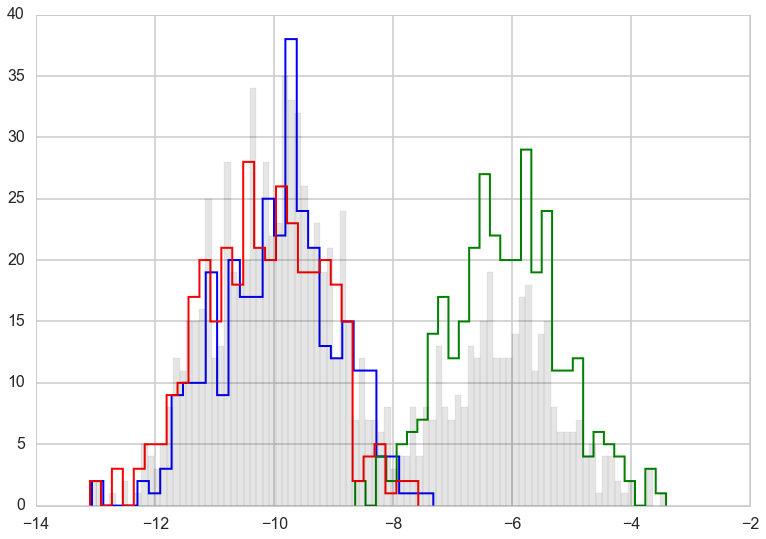

In [79]:
from collections import defaultdict
data = []
data_resp=defaultdict(list)
plt.figure(1)
for i in range(n):
    # pick category
    mean = np.dot(mixture_selection_matrix[N[i]], mu)
    cov = np.dot(mixture_selection_matrix[N[i]], var_arr)*var
    # get point from distribution
    x = np.random.normal(mean, cov)
    data.append(x)
    data_resp[N[i]].append(x)
#fig = plt.scatter(x[0], x[1], s=50, c=color[N[i]])
for k in range(K):
    plt.hist(data_resp[k], bins=30, color=color[k], histtype='step', lw=2)
plt.hist(data, color='k', bins=90, alpha=0.1);

In [80]:
# Variational Inference - CAVI

def VI(K, prior_std, n, data):
    # Initialization
    mu_mean = []
    mu_var = []
    for i in range(K):
        mu_mean.append(np.random.normal(0, prior_std))
        mu_var.append(abs(np.random.normal(0, prior_std)))
    
    c_est = np.zeros((n, K))
    for i in range(n):
        c_est[i, np.random.choice(K)] = 1
        
    # Initiate CAVI iterations
    while(True):
        mu_mean_old = mu_mean[:]
        
        # mixture model parameter update step
        for j in range(K):
            nr = 0
            dr = 0
            for i in range(n):
                nr += c_est[i, j]*data[i]
                dr += c_est[i, j]
            mu_mean[j] = nr/((1/prior_std**2) + dr)
            mu_var[j] = 1.0/((1/prior_std**2) + dr)


        # categorical vector update step
        for i in range(n):
            cat_vec = []
            for j in range(K):
                cat_vec.append(math.exp(mu_mean[j]*data[i] - (mu_var[j] + mu_mean[j]**2)/2))
            for k in range(K):
                c_est[i, k] = cat_vec[k]/np.sum(np.array(cat_vec))
                
        # compute ELBO or check for convergence of variational factors - here we do the latter
        if np.dot(np.array(mu_mean_old) - np.array(mu_mean), np.array(mu_mean_old) - np.array(mu_mean)) < 0.000001:
            break

    # sort the values since the k mixture components dont maintain any ordering across multiple initializations
    mixture_components = list(zip(mu_mean, mu_var))
    mixture_components.sort()
    return mixture_components, c_est



3 || [(-10.246656836012605, 0.0029582744568587794), (-9.8555865920976, 0.0029576711149214051), (-6.1344111302908857, 0.0030874560481785772)] || [[  3.94909207e-01   5.91865216e-01   1.32255771e-02]
 [  6.14226119e-01   3.85771686e-01   2.19455220e-06]
 [  5.16656028e-01   4.83222415e-01   1.21557818e-04]
 ..., 
 [  3.62670138e-05   1.98514496e-04   9.99765218e-01]
 [  5.96906027e-01   4.03089401e-01   4.57180378e-06]
 [  4.47703196e-01   5.50428571e-01   1.86823221e-03]]


//anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


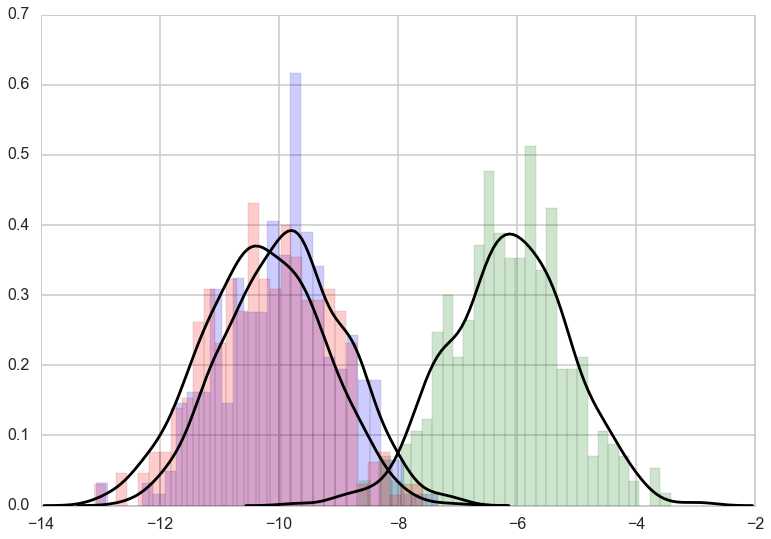

In [85]:
# Run the CAVI algorithm
mixture_components, c_est = VI(K, prior_std, n, data)

print(K,"||",mixture_components, "||", c_est)
for k in range(K):
    plt.hist(data_resp[k], bins=30, color=color[k], alpha=0.2, normed=True)
for k in range(K):
    vals=np.random.normal(mixture_components[k][0], 1, size=1000)
    sns.kdeplot(vals,  color='k');

### In practice considerations

Some considerations to keep in mind when implementing such stochastic numerical routines -   
1) The output can be sensitive to initialization values and thus iterating multiple times to find a relatively good local optimum is a good strategy 
2) Look out for numerical stability issues - quite common when dealing with tiny probabilities  
3) Ensure algorithm converges before using the result

## Primary references
1) Pattern Recognition and Machine Learning, Bishop (2006)  
2) Variational Inference: a review for Statisticians, Blei et al (2016)  
